Libraries and Frameworks 

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import nbconvert
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV


In [58]:
waveforms = np.load('Waveform.npy')

Examine Shape of Waveforms

In [59]:
waveforms[:,:,0].shape

(368, 400)

Visualize 1D Data: Channel 1 (EKG)

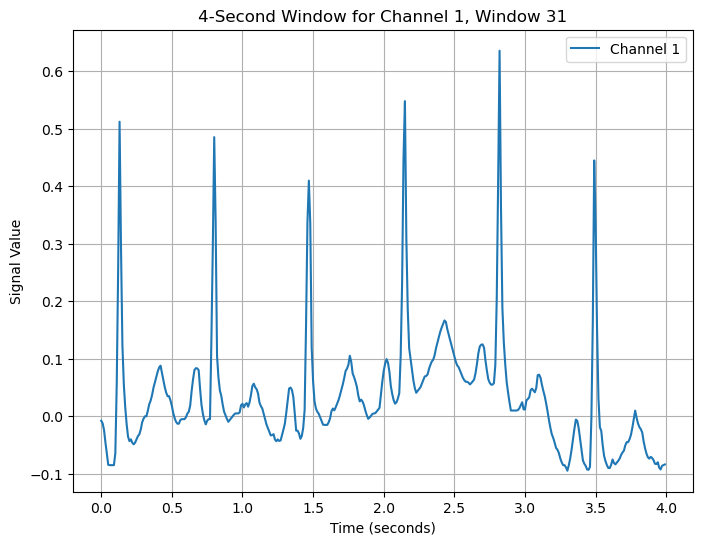

In [60]:
channel = 0 #change this to select desired channel (EKG)
window = 31  # You can change this to select other windows (1st waveform) 
selected_frame =  waveforms[window, :, channel]

# Plot waveform for selected channel (measure type) and window (4 second sample) 
time = np.arange(400) / 100  #create 400 time points

plt.figure(figsize=(8, 6)) #Select size of display window 

plt.plot(time, selected_frame, label=f'Channel {channel + 1}')

plt.title(f'4-Second Window for Channel {channel+1}, Window {window}')
plt.xlabel('Time (seconds)')
plt.ylabel('Signal Value')
plt.legend()
plt.grid(True)
plt.show()

Feature Extraction: Fourier Transform Coefficients from ECG Waveform 

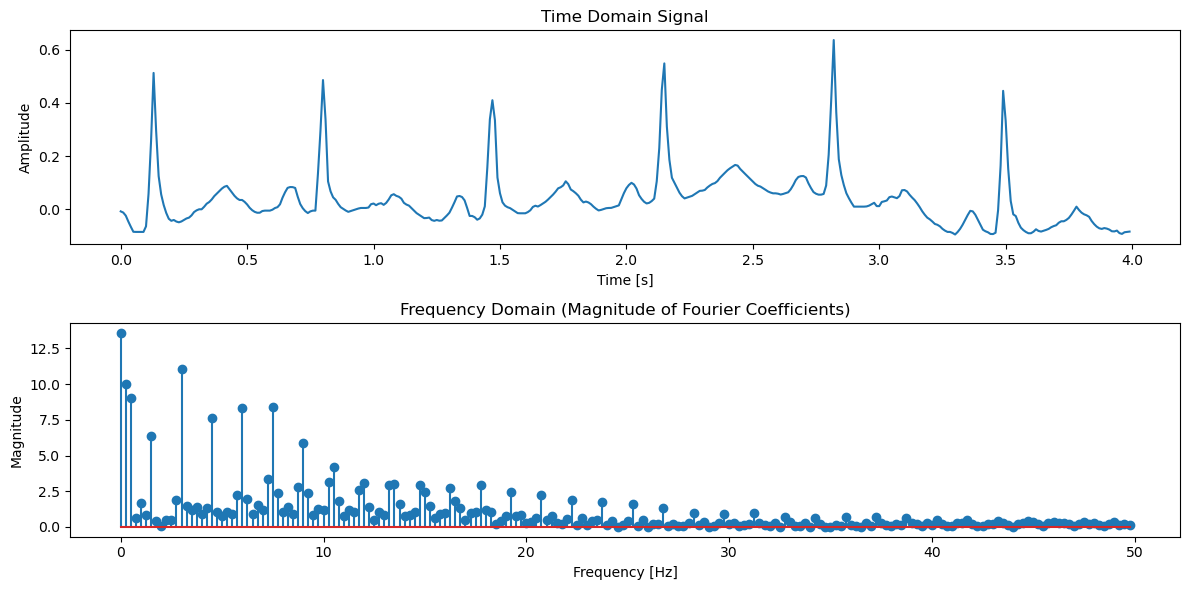

In [61]:
#Establish Waveform Characteristics 
Fs = 100  # Sampling frequency (samples per second)
T = 1 / Fs  # Sampling period (seconds per sample)
t = np.arange(0, 4, 1/100)  # Time vector (4 seconds)

#Compute the Fourier Transform (FFT)
fourier_coefficients = np.fft.fft(selected_frame)

#Get the frequency axis
n = len(selected_frame)  # Number of samples
frequencies = np.fft.fftfreq(n, T)  # Frequency components corresponding to FFT output

#Get the magnitude of the Fourier coefficients
magnitude = np.abs(fourier_coefficients)

#Plot the signal and its Fourier Transform
plt.figure(figsize=(12, 6))

# Plot the time-domain signal
plt.subplot(2, 1, 1)
plt.plot(t, selected_frame)
plt.title('Time Domain Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

#Plot the magnitude of Fourier coefficients (frequency domain)
plt.subplot(2, 1, 2)
plt.stem(frequencies[:n // 2], magnitude[:n // 2])  # Plot half of the spectrum (positive frequencies)
plt.title('Frequency Domain (Magnitude of Fourier Coefficients)')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')

plt.tight_layout()
plt.show()

Linear Regression Model 

0. Prepare Data  

In [62]:
#Sample Data(Fourier Coefficients): 368 x 800 x 1 (Windows x Data Points x ECG channel) 
phys_meas = {'ekg': 0, 'ppg': 1,'prox': 2, 'nibp_sys': 3,'nibp_dias': 4, 'nibp_mean': 5, 'abp': 6,'cvp': 7}
n_samples = waveforms.shape[0]
n_features = waveforms.shape[1]*2

#Input: Fourier coefficients, shape:(samples, features)
X = np.empty((n_samples,n_features), dtype = float)

for x in range(n_samples):
    window_fc = np.fft.fft(waveforms[x,:,phys_meas['ekg']]) #compute the fourier coefficient for each 4s window 
    X[x, :400] = window_fc.real
    X[x, 400:] = window_fc.imag

#Targets: Mean CVP Values, shape: (mean values)
y = np.mean(waveforms[:, :, 7], axis = 1) 

#Format both inputs and targets 
X = torch.from_numpy(X.astype(np.float32))
y = torch.from_numpy(y.astype(np.float32))
y = y.view(y.shape[0],1) #reshape tensor to create a one column array 
                                     
#Designate training, validation and test sets 
# First split: Training/Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

1. Model

In [63]:
input_size = n_features 
output_size = 1
model = nn.Linear(input_size, output_size) #model takes in 800 features (multiple linear regression)

2. Loss and Optimizer 

In [64]:
learning_rate = 0.001
criterion = nn.MSELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) #Stochastic Gradient Descent evaluates each example

3. Training loop

In [65]:
num_epochs = 10000
for epoch in range(num_epochs):
    # forward pass and loss
    y_predicted = model(X_train)
    loss = criterion(y_predicted, y_train) #assesses difference between predicted and expected 

    # backward pass
    loss.backward() #computes gradient (vector) of loss
    
    # update 
    optimizer.step() #applies gradient (vector) update 
    
    optimizer.zero_grad() #clears gradient from previous iteration so new gradient can be applied
    
    if (epoch+1) %10 == 0:
        print(f'epoch: {epoch+1}, loss = {loss.item():.4f}')

epoch: 10, loss = 133.8514
epoch: 20, loss = 118.3652
epoch: 30, loss = 108.2199
epoch: 40, loss = 100.4412
epoch: 50, loss = 94.0443
epoch: 60, loss = 88.5793
epoch: 70, loss = 83.7963
epoch: 80, loss = 79.5394
epoch: 90, loss = 75.7036
epoch: 100, loss = 72.2144
epoch: 110, loss = 69.0166
epoch: 120, loss = 66.0681
epoch: 130, loss = 63.3359
epoch: 140, loss = 60.7934
epoch: 150, loss = 58.4190
epoch: 160, loss = 56.1949
epoch: 170, loss = 54.1057
epoch: 180, loss = 52.1387
epoch: 190, loss = 50.2829
epoch: 200, loss = 48.5286
epoch: 210, loss = 46.8675
epoch: 220, loss = 45.2923
epoch: 230, loss = 43.7963
epoch: 240, loss = 42.3738
epoch: 250, loss = 41.0196
epoch: 260, loss = 39.7291
epoch: 270, loss = 38.4979
epoch: 280, loss = 37.3222
epoch: 290, loss = 36.1986
epoch: 300, loss = 35.1238
epoch: 310, loss = 34.0949
epoch: 320, loss = 33.1094
epoch: 330, loss = 32.1646
epoch: 340, loss = 31.2583
epoch: 350, loss = 30.3885
epoch: 360, loss = 29.5531
epoch: 370, loss = 28.7503
epoch:

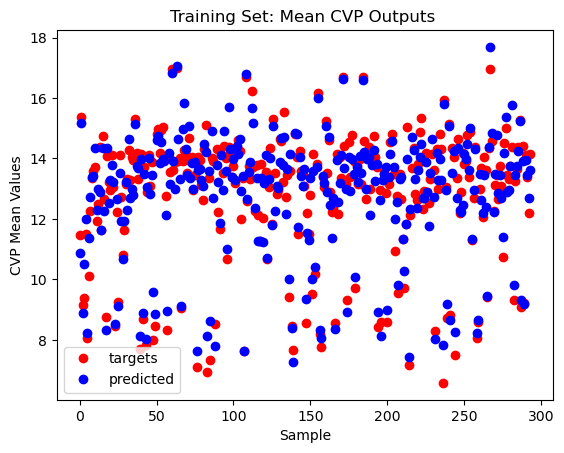

In [66]:
#plot 
x_axis = np.arange(0,X_train.shape[0])

#extract predicted values 
predicted = model(X_train).detach().numpy()

#plot target values and predicted values 
plt.plot(x_axis, y_train, 'ro', label = 'targets')
plt.plot(x_axis, predicted, 'bo', label = 'predicted')

#label graph
plt.xlabel('Sample')
plt.ylabel('CVP Mean Values')
plt.title('Training Set: Mean CVP Outputs ')
plt.legend()

#show the plot 
plt.show()

4. Test model on unbias data 

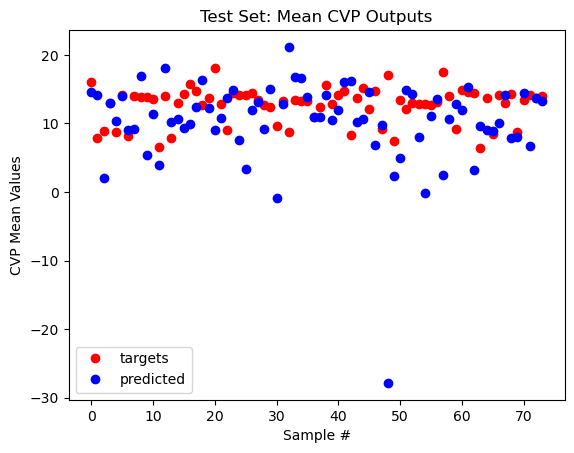

Mean Squared Error: 53.19532775878906
R-squared: -7.001125190416317


In [67]:
#forward pass using X_test data
y_pred = model(X_test).detach().numpy()
x_axis = np.arange(0,X_test.shape[0])

#plot target values and predicted values 
plt.plot(x_axis, y_test, 'ro', label = 'targets')
plt.plot(x_axis, y_pred, 'bo', label = 'predicted')

#label graph
plt.xlabel('Sample #')
plt.ylabel('CVP Mean Values')
plt.title('Test Set: Mean CVP Outputs')
plt.legend()

#show the plot 
plt.show()

#Compare the y_predicted with target y values 
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Analysis: 